In [51]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
import cvxpy as cvx

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from group import compute_group_coverages, compute_split_coverages 
from group import compute_group_qr_coverages, compute_cqr_coverages
from Synthetic_data_generation import get_groups, generate_group_synthetic_data, generate_cqr_data
from rkhs import compute_shifted_coverage, compute_qr_coverages, compute_adaptive_threshold
from sklearn.metrics.pairwise import pairwise_kernels


### Experiment on grouped data

In [53]:
def run_group_synthetic_trial(n, x_std, y_std, d, std_dev_list, theta, n_test, n_cal,
                              n_groups, alpha, exact=True, eps = 0.0001):
    
    x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_group_synthetic_data(
        n, x_std, y_std, d, std_dev_list, theta, n_test, n_cal, n_groups
    )

    groups_train = get_groups(x_train_final[:,0:n_groups])
    groups_calib = get_groups(x_calib[:,0:n_groups])
    groups_test = get_groups(x_test[:,0:n_groups])

    groups_train_joined = np.vstack([groups_train,groups_calib])
    y_train_joined = np.concatenate((y_train_final,y_calib))
    
    adaptive_coverages = compute_group_coverages(
        groups_train_joined, y_train_joined, y_test, groups_test[0:n_test,:], groups_test[0:n_test,:],
        alpha, exact = exact, eps = eps
    )
    qr_coverages = compute_group_qr_coverages(
        groups_train_joined, groups_test, y_train_joined, y_test, alpha, eps = eps
    )
    cqr_coverages = compute_cqr_coverages(
        groups_train, groups_calib, groups_test, y_train_final, y_calib, y_test, alpha
    )

    adapt_cover = pd.Series(adaptive_coverages)
    qr_cover = pd.Series(qr_coverages)
    cqr_cover = pd.Series(cqr_coverages)

    df = pd.concat([adapt_cover, qr_cover, cqr_cover], keys=["adaptive", "qr", "cqr"], axis=1).reset_index()
    return df


In [88]:
df = pd.DataFrame()
ntrials = 100
alpha = 0.9
n_train = 50
n_cal = 50
n_test = 200
n = n_train + n_cal + n_test

# Parameters for data generation 
x_std = 0.1
y_std = 0.25
n_groups = 5
d = n_groups + 5 # choose d > n_groups

std_dev_list = np.array([20,0.001,1,1,1] ) ## must be of length n_groups

theta = np.random.normal(loc=np.zeros(d), scale=x_std)
for i in range(ntrials):
    try:
        append_df = run_group_synthetic_trial(n, x_std, y_std, d, std_dev_list, theta, n_test, n_cal, n_groups, alpha=alpha)
        append_df['trial'] = i
        df = pd.concat([df, append_df])
    except SolverError:
        print("one solver error")
        continue

100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 53.47it/s]


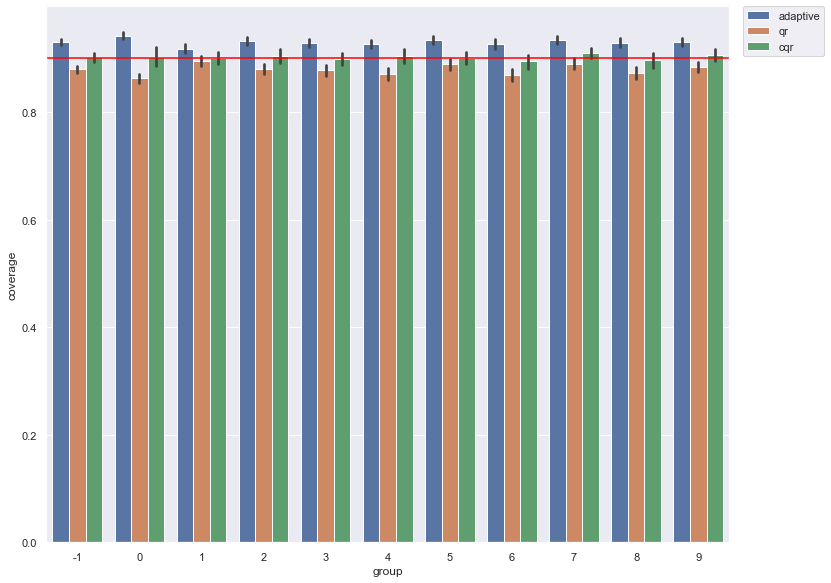

In [95]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

melted_df = pd.melt(df, id_vars=["index"], value_vars=["adaptive", "qr", "cqr"])
melted_df = melted_df.rename(columns={"index": "group", "value": "coverage"})
#melted_df = melted_df[melted_df["group"] <=5]

fig = sns.barplot(melted_df, 
            x="group", y="coverage", hue="variable")
fig.axhline(alpha,color='red')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig('figures/GroupCoverageComparison.png')

### Experiment on RKHS Data

In [178]:
def compute_coverage_at_shift(x_test,scores_test,thresholds,shift_loc,gamma, eps = 0.0001):
    g = pairwise_kernels(
                X=np.array([shift_loc]).reshape(1,-1),
                Y=x_test,
                metric="rbf",
                gamma=gamma
            )[0,:]
    return np.average(scores_test <= thresholds+eps, weights=g)

In [180]:
def run_rkhs_synthetic_trial(n_calib, n_test, alpha, radius, shift_locs, gamma, eps = 0.0001):

    x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(
                                                                        n_train = 2*n_calib,
                                                                        n_test = n_test)
    z_calib = pairwise_kernels(
                X=x_calib,
                Y=np.array(shift_locs).reshape(len(shift_locs),1),
                metric="rbf",
                gamma=gamma
            )
    z_calib = np.column_stack((z_calib,np.ones(len(x_calib))))
    z_test = pairwise_kernels(
                X=x_test,
                Y=np.array(shift_locs).reshape(len(shift_locs),1),
                metric="rbf",
                gamma=gamma
            )
    z_test = np.column_stack((z_test,np.ones(len(x_test))))

    reg = LinearRegression().fit(x_train_final, y_train_final)
    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    scores_test = np.abs(reg.predict(x_test) - y_test)

    _, adaptive_coverage, adaptive_thresholds = compute_shifted_coverage(
        scores_test,
        scores_calib,
        x_calib,
        x_test,
        None,
        kernel="rbf",
        alpha=alpha,
        radius=radius,
        gamma=gamma,
        z_calib=z_calib,
        z_test=z_test,
        exact=True,
        eps=eps
    )
    qr_coverage, qr_thresholds = compute_qr_coverages(x_calib, x_test, scores_calib, 
                                        scores_test, alpha, gamma, radius, "rbf", z_calib,
                                                      z_test, eps
                                 )

    q = np.quantile(scores_calib, [alpha * (1 + 1/len(scores_calib))])
    conformal_thresholds = q
    conformal_coverage = np.mean(scores_test <= conformal_thresholds+eps)
    
    results_df = pd.DataFrame({'coverage' : [adaptive_coverage, qr_coverage, conformal_coverage],
                             'type' : ['robust','qr','split'],'shift_loc' : ['None','None','None']})
    for shift in shift_loc:
        shift_adaptive_cov = compute_coverage_at_shift(x_test, scores_test, 
                                                       adaptive_thresholds, shift, gamma, eps)
        shift_qr_cov = compute_coverage_at_shift(x_test, scores_test, qr_thresholds,
                                                 shift, gamma, eps)
        shift_split_cov = compute_coverage_at_shift(x_test, scores_test, conformal_thresholds,
                                                    shift, gamma, eps)
        
        shift_df = pd.DataFrame({'coverage' : [shift_adaptive_cov, shift_qr_cov, shift_split_cov],
                             'type' : ['robust','qr','split'],'shift_loc' : [shift,shift,shift]})
        
        results_df = pd.concat([results_df,shift_df])
        
    return results_df

ntrials = 20
alpha = 0.9
n_calib = 100
n_test = 300                                             
#radius = 1
gamma = 2
shift_loc = [0.5, 1.4, 2.5, 3.5, 4.5]
#shift_loc = [3.5,4.5]

radii=[1,100,1000,5000,100000]
#radii=[1000]

cqr_df = pd.DataFrame()
for radius in radii:
    for i in range(ntrials):
        try:
            append_df = run_rkhs_synthetic_trial(n_calib, n_test, alpha,
                                         radius, shift_loc, gamma)
            append_df['trial'] = i
            append_df['radius'] = radius
            cqr_df = pd.concat([cqr_df, append_df])
        except cvx.error.SolverError:
            print("one solver error")
            continue


100%|█████████████████████████████████████████| 300/300 [00:09<00:00, 30.48it/s]


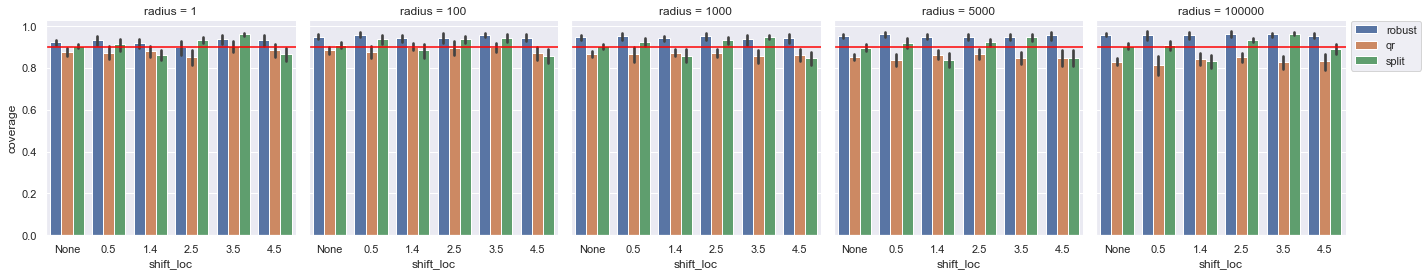

In [183]:
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})

def make_coverage_barplot(x,y,hue,**kwargs):
    fig = sns.barplot(x=x,y=y,hue=hue)
    fig.axhline(alpha,color='red')
    
fig = sns.FacetGrid(cqr_df, col="radius",height=4) 
fig.map(make_coverage_barplot,"shift_loc","coverage","type")
#fig.add_legend()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

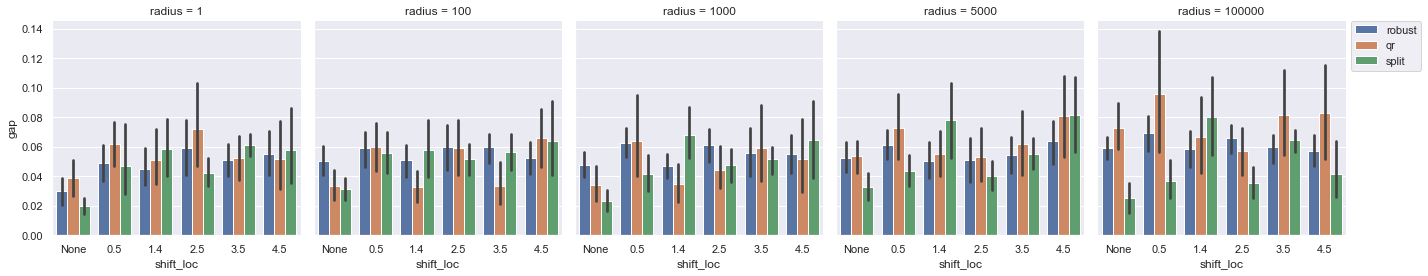

In [184]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

cqr_df['gap'] = np.abs(cqr_df['coverage'] - 0.9)

def make__gap_barplot(x,y,hue,**kwargs):
    fig = sns.barplot(x=x,y=y,hue=hue)

fig = sns.FacetGrid(cqr_df, col="radius",height=4) 
fig.map(make__gap_barplot,"shift_loc","gap","type")
#fig.add_legend()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

### Finite Dim Regression Example

In [58]:
def run_FD_trial(n_calib,n_test,alpha,shift_locs,dimension,a=1,b=1,gamma=2,eps=0.0001):
    x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(
                                                                        2*n_calib,
                                                                        n_test,
                                                                        a,b)
    rkhs_basis_points = np.linspace(0,5,dimension)
    
    z_calib = pairwise_kernels(
                X=x_calib,
                Y=rkhs_basis_points.reshape(len(rkhs_basis_points),1),
                metric="rbf",
                gamma=gamma
            )
    z_calib = np.column_stack((z_calib,np.ones(len(x_calib))))
    z_test = pairwise_kernels(
                X=x_test,
                Y=rkhs_basis_points.reshape(len(rkhs_basis_points),1),
                metric="rbf",
                gamma=gamma
            )
    z_test = np.column_stack((z_test,np.ones(len(x_test))))

    reg = LinearRegression().fit(x_train_final, y_train_final)
    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    scores_test = np.abs(reg.predict(x_test) - y_test)

    _, adaptive_coverage, adaptive_thresholds = compute_shifted_coverage(
        scores_test,
        scores_calib,
        x_calib,
        x_test,
        None,
        kernel=None,
        alpha=alpha,
        radius=None,
        gamma=None,
        z_calib=z_calib,
        z_test=z_test,
        exact=True,
        eps=eps
    )
    qr_coverage, qr_thresholds = compute_qr_coverages(None, None, scores_calib, 
                                        scores_test, alpha, None, None, None, z_calib,
                                                      z_test, eps
                                 )

    q = np.quantile(scores_calib, [alpha * (1 + 1/len(scores_calib))])
    conformal_thresholds = q
    conformal_coverage = np.mean(scores_test <= conformal_thresholds+eps)
    
    results_df = pd.DataFrame({'Coverage' : [adaptive_coverage, qr_coverage, conformal_coverage],
                             'type' : ['Robust','QR','Split'],'Shift Loc' : ['Marginal','Marginal','Marginal']})
    for shift in shift_loc:
        shift_adaptive_cov = compute_coverage_at_shift(x_test, scores_test, 
                                                       adaptive_thresholds, shift, gamma, eps)
        shift_qr_cov = compute_coverage_at_shift(x_test, scores_test, qr_thresholds,
                                                 shift, gamma, eps)
        shift_split_cov = compute_coverage_at_shift(x_test, scores_test, conformal_thresholds,
                                                    shift, gamma, eps)
        
        shift_df = pd.DataFrame({'Coverage' : [shift_adaptive_cov, shift_qr_cov, shift_split_cov],
                             'type' : ['Robust','QR','Split'],'Shift Loc' : [shift,shift,shift]})
        
        results_df = pd.concat([results_df,shift_df])
        
    return results_df

ntrials = 20
alpha = 0.9
n_calib = 200
n_test = 200                                             
#shift_loc = [0.5, 1.4, 2.5, 3.5, 4.5]
#shift_loc = [3.5,4.5]
shift_loc = []
a=1
b=1

dimensions=[1,5,10,20,30,50]

cqr_df = pd.DataFrame()
for d in dimensions:
    for i in range(ntrials):
        try:
            append_df = run_FD_trial(n_calib, n_test, alpha,
                                                 shift_loc, d, a, b)
            append_df['trial'] = i
            append_df['Dimension'] = d
            cqr_df = pd.concat([cqr_df, append_df])
        except cvx.error.SolverError:
            print("one solver error")
            continue


100%|█████████████████████████████████████████| 200/200 [00:07<00:00, 26.73it/s]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 37.89it/s]


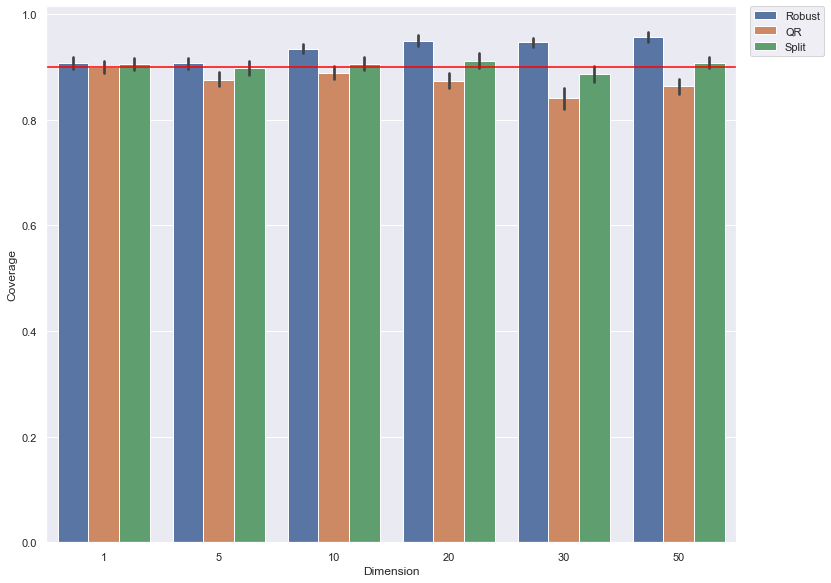

In [91]:
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})

# def make_coverage_barplot(x,y,hue,**kwargs):
#     fig = sns.barplot(x=x,y=y,hue=hue)
#     fig.axhline(alpha,color='red')
    
# fig = sns.FacetGrid(cqr_df, col="Dimension",height=4) 
# fig.map(make_coverage_barplot,"Shift Loc","Coverage","type")
# #fig.add_legend()
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.tight_layout()

# print(np.mean(cqr_df['Coverage'][cqr_df['type'] == 'Robust']))
# print(np.mean(cqr_df['Coverage'][cqr_df['type'] == 'QR']))

fig = sns.barplot(cqr_df, x="Dimension",y="Coverage",hue="type") 

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.axhline(alpha,color='red')
plt.tight_layout()
plt.savefig('figures/OneDimManyRBFsCoverage.png')

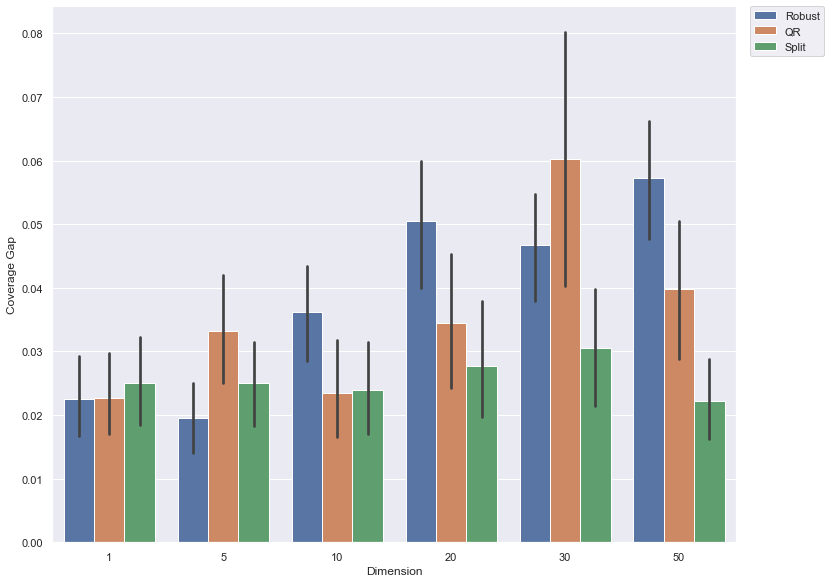

In [92]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

cqr_df['Coverage Gap'] = np.abs(cqr_df['Coverage'] - alpha)

# def make__gap_barplot(x,y,hue,**kwargs):
#     fig = sns.barplot(x=x,y=y,hue=hue)

# fig = sns.FacetGrid(cqr_df, col="Dimension",height=4) 
# fig.map(make__gap_barplot,"Shift Loc","Coverage Gap","type")
# #fig.add_legend()
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.tight_layout()


fig = sns.barplot(cqr_df, x="Dimension",y="Coverage Gap",hue="type") 

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig('figures/OneDimManyRBFsGap.png')

### High Dimensional Experiment

In [43]:
def generate_high_dim_data(n_train,n_calib,n_test,d):
    n = n_train + n_calib + n_test
    X = np.random.uniform(size = (n,d))
    
    betas = np.random.normal(0,1,2*d)
    sds = 1+(X@betas[0:d] + 2*(X*X) @ betas[d:])/d
    sds = np.maximum(sds,0.5)

    y = np.random.normal(loc = 0, scale = sds, size = n)
    
    X = np.column_stack((X,np.ones(n)))
    
    x_train = X[0:n_train,:]
    x_calib = X[n_train:(n_train + n_calib),:]
    x_test = X[(n_train + n_calib):,:]
    
    y_train = y[0:n_train]
    y_calib = y[n_train:(n_train + n_calib)]
    y_test = y[(n_train + n_calib):]
    
    return x_train, y_train, x_calib, y_calib, x_test, y_test

def run_HD_trial(n_calib,n_test,alpha,d,eps=0.0001):
    x_train, y_train, x_calib, y_calib, x_test, y_test = generate_high_dim_data(n_calib,
                                                                        n_calib,
                                                                        n_test,d)

    reg = LinearRegression().fit(x_train, y_train)
    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
    scores_test = np.abs(reg.predict(x_test) - y_test)

    _, adaptive_coverage, adaptive_thresholds = compute_shifted_coverage(
        scores_test,
        scores_calib,
        x_calib,
        x_test,
        None,
        kernel=None,
        alpha=alpha,
        radius=None,
        gamma=None,
        z_calib=x_calib,
        z_test=x_test,
        exact=True,
        eps=eps
    )
    qr_coverage, qr_thresholds = compute_qr_coverages(None, None, scores_calib, 
                                        scores_test, alpha, None, None, None, x_calib,
                                                      x_test, eps
                                 )

    q = np.quantile(scores_calib, [alpha * (1 + 1/len(scores_calib))])
    conformal_thresholds = q
    conformal_coverage = np.mean(scores_test <= conformal_thresholds+eps)
    
    results_df = pd.DataFrame({'Coverage' : [adaptive_coverage, qr_coverage, conformal_coverage],
                             'type' : ['Robust','QR','Split']})
        
    return results_df


In [59]:
ntrials = 20
alpha = 0.9
n_calib = 200
n_test = 200                                             

dimensions=[1,5,10,20,30,50]

high_dim_df = pd.DataFrame()
for d in dimensions:
    for i in range(ntrials):
        try:
            append_df = run_HD_trial(n_calib, n_test, alpha, d)
            append_df['trial'] = i
            append_df['Dimension'] = d
            high_dim_df = pd.concat([high_dim_df, append_df])
        except cvx.error.SolverError:
            print("one solver error")
            continue

100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 40.34it/s]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 42.51it/s]


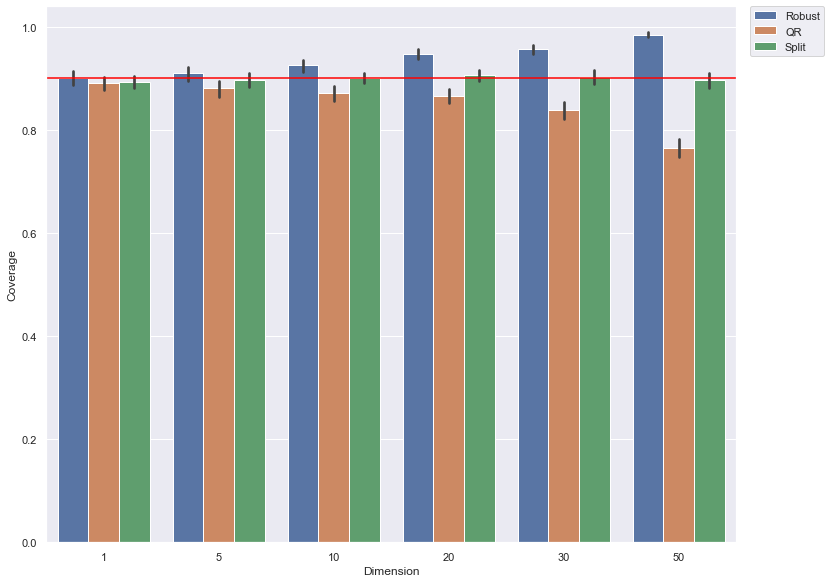

In [93]:
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})
    
fig = sns.barplot(high_dim_df, x="Dimension",y="Coverage",hue="type") 

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.axhline(alpha,color='red')
plt.tight_layout()
plt.savefig('figures/HighDimLQRCoverage.png')

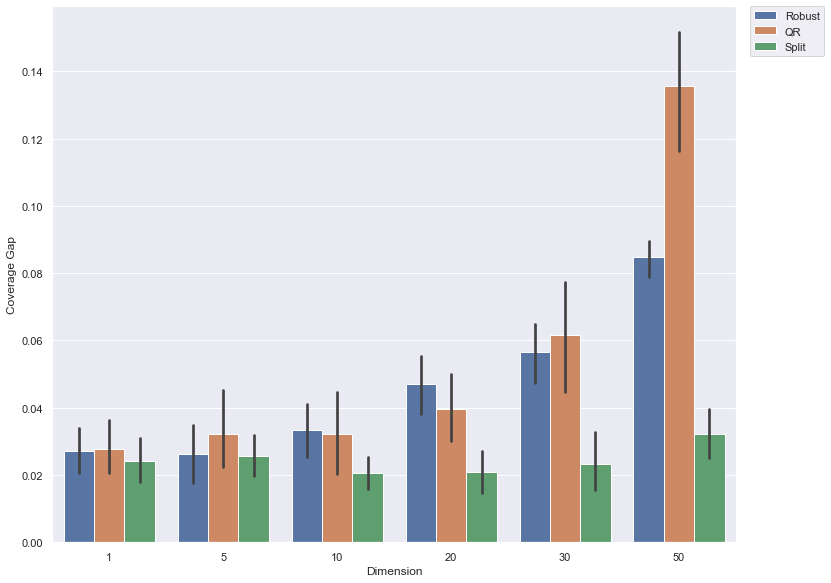

In [94]:
high_dim_df['Coverage Gap'] = np.abs(high_dim_df['Coverage'] - alpha)

fig = sns.barplot(high_dim_df, x="Dimension",y="Coverage Gap",hue="type") 

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig('figures/HighDimLQRCoverageGap.png')